### Welcome to our project about birdsong classification for a select subset of American Warblers!

    - Beck, Carly, River, Solomon

In [ ]:
# imports <3

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import os
import numpy as np
import matplotlib.pyplot as plt

# Data Preprocessing
- Load the data
- Split into test/train sets
- Resize and format into datasets
- Normalize images

In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
# Define the dataset directory and parameters
# data_dir = os.getcwd() + "/data/spectrograms_windowed_dataset"  # dataset path?
data_dir = os.getcwd() + "/spectrograms_windowed_dataset"  # dataset path?
batch_size = 32
img_size = (IMAGE_HEIGHT, IMAGE_WIDTH)  # Resize all images to 224x224

# Load the full dataset without splitting
full_ds = image_dataset_from_directory(
    data_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int',  # Use integer labels
    shuffle=False  # Do not shuffle so we can later use stratified split
)

# Extract images and labels
image_paths = []
labels = []

for image, label in full_ds:
    # Collect the image file paths and corresponding labels
    image_paths.extend(image.numpy())
    labels.extend(label.numpy())

# Convert labels to numpy array for stratified splitting
labels = np.array(labels)

# Perform stratified split to maintain class distribution
train_images, val_images, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=123
)

# Create datasets from the split data
def create_dataset(image_paths, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (tf.image.resize(x, img_size), y))  # Resize images
    dataset = dataset.batch(batch_size)
    return dataset

train_ds = create_dataset(train_images, train_labels, batch_size)
val_ds = create_dataset(val_images, val_labels, batch_size)

# Optional: Cache datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalize images (scale pixel values to [0, 1])
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


Found 6690 files belonging to 20 classes.


# Plot Class Distribution
- Gather class names + occurences
- Build + label a chart of validation and training counts
- Display the plot

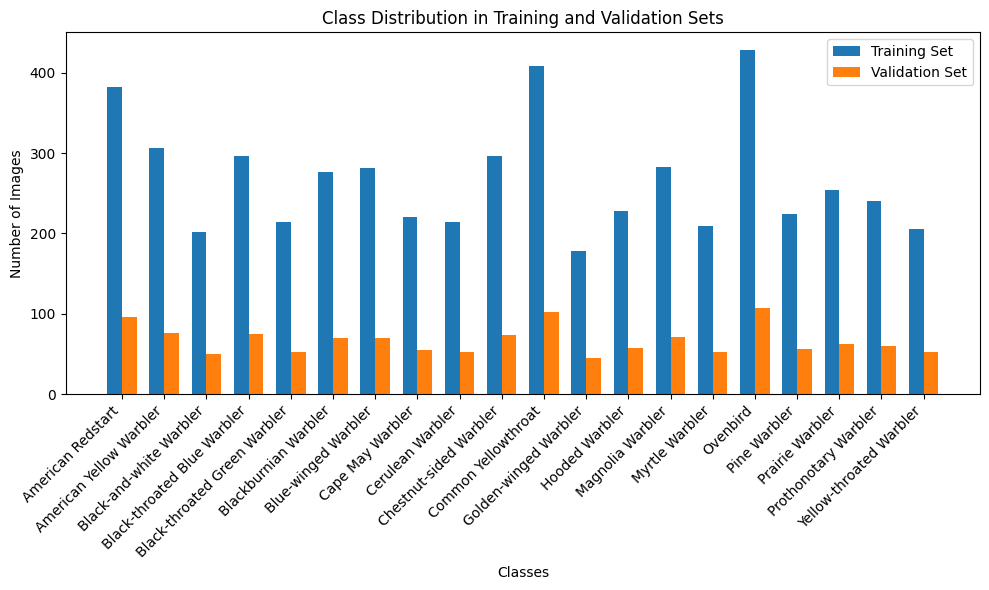

In [ ]:
# Get class names from the subdirectories inside the data directory
class_names = sorted(os.listdir(data_dir))  # List all subdirectories (class names)
class_names = [name for name in class_names if os.path.isdir(os.path.join(data_dir, name))]  # Filter out non-directory files

# Initialize empty dictionaries to count class occurrences
train_class_count = {class_name: 0 for class_name in class_names}
val_class_count = {class_name: 0 for class_name in class_names}

# Count class occurrences in train_ds
for _, labels in train_ds:
    for label in labels.numpy():
        class_name = class_names[label]
        train_class_count[class_name] += 1

# Count class occurrences in val_ds
for _, labels in val_ds:
    for label in labels.numpy():
        class_name = class_names[label]
        val_class_count[class_name] += 1

# Plotting the class distribution
train_counts = list(train_class_count.values())
val_counts = list(val_class_count.values())
x = np.arange(len(class_names))  # set the positions for the bars
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
bar1 = ax.bar(x - bar_width/2, train_counts, bar_width, label='Training Set')
bar2 = ax.bar(x + bar_width/2, val_counts, bar_width, label='Validation Set')

# Labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution in Training and Validation Sets')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


# Build Model
- Define our `build_cnn` function
- Build + compile it

In [ ]:
# Define CNN architecture
def build_cnn(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes=20):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Regularization to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

# Instantiate the model
num_classes = 20 
model = build_cnn(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes=num_classes)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


c:\Users\rmarshall26\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,540 (42.62 MB)

 Trainable params: 11,171,540 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model
- Define `early_stopping` callback
- Train on `train_ds`

In [5]:
# Define the EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode = 'min',
    patience=4,
    restore_best_weights=True,
    verbose =1
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.0753 - loss: 3.1579 - val_accuracy: 0.1570 - val_loss: 2.6338
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.1987 - loss: 2.5931 - val_accuracy: 0.3580 - val_loss: 2.0619
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.3448 - loss: 2.0547 - val_accuracy: 0.5037 - val_loss: 1.5743
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.5019 - loss: 1.5508 - val_accuracy: 0.6435 - val_loss: 1.1799
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.5880 - loss: 1.2525 - val_accuracy: 0.6734 - val_loss: 1.0224
Epoch 6/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.6833 - loss: 0.9557 - val_accuracy: 0.6936 - val_loss: 0.9680
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.7280 - loss: 0.8264 - val_accuracy: 0.7138 - val_loss: 0.9040
Epoch 8/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.7781 - loss: 0.6647 - val_accu

# Evaluate Model
- Use `val_ds` to validate the trained model
- Print validation accuracy
- Plot test vs validation accuracy + loss
- Plot confusion matrix

In [6]:
# Evaluate on the validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2f}")


42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.7547 - loss: 0.8523
Validation Accuracy: 0.75


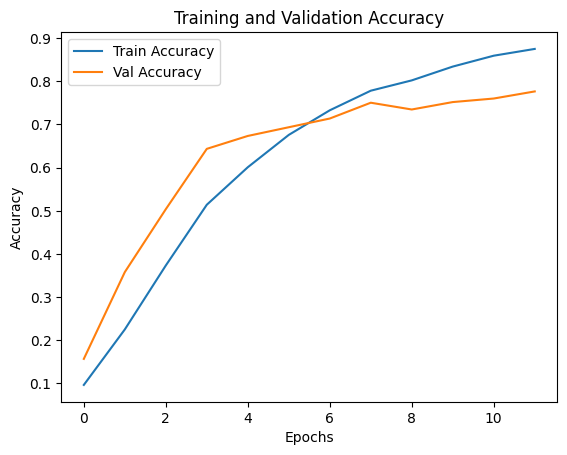

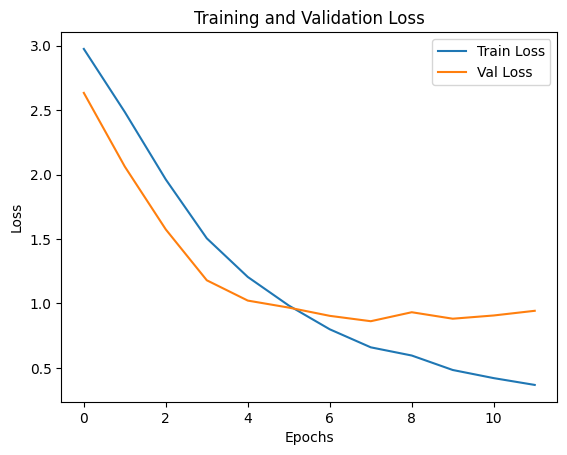

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
import matplotlib.pyplot as plt

# actual labels
y_true = []
for _, labels in val_ds:
    y_true.extend(labels.numpy())
    
# predicted labels
y_pred = []
for images, _ in val_ds:
    y_pred.extend(np.argmax(model.predict(images), axis=1))
    
# make the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

In [ ]:
# plot the confusion matrix
plt.figure(figsize=(12, 12))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

# normalize it
# conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# white text if squares are dark; otherwise black
text_colors = [['black' if conf_matrix[i, j] < 0.5 else 'white' for j in range(len(class_names))] for i in range(len(class_names))]
thresh = conf_matrix.max() / 2.

# put the numbers on the plot
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, f'{conf_matrix[i, j]:.2f}', horizontalalignment='center', color=text_colors[i][j])
    
# show the plot
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()